# Gerenciamento de Capital em Operações de Trade usando Lógica Fuzzy

Letra `c` e `d`

## Import

In [762]:
# data analysis
import numpy as np

# fuzzy
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# others
import warnings
import pprint
import time
import os

## Cell Format

In [763]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# Guarantees visualization inside the jupyter
%matplotlib inline

# Supress unnecessary warnings so that presentation looks clean
warnings.filterwarnings('ignore')

# pretty print
pp = pprint.PrettyPrinter(indent=4)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Variáveis

In [764]:
x_liquedez_acao = ctrl.Antecedent(np.arange(0, 2000, 1), 'x_liquedez_acao')
x_indicador_rsi = ctrl.Antecedent(np.arange(0, 100, 1), 'x_indicador_rsi')
x_trades_errados = ctrl.Antecedent(np.arange(0, 10, 1), 'x_trades_errados')

y_tamanho_entrada = ctrl.Consequent(np.arange(0, 20, 1), 'y_tamanho_entrada')

## Conjuntos de pertinência

In [765]:
x_liquedez_acao['baixa'] = fuzz.trapmf(x_liquedez_acao.universe, [0, 0, 100, 500])
x_liquedez_acao['medio'] = fuzz.trapmf(x_liquedez_acao.universe, [300, 500, 700, 900])
x_liquedez_acao['alta'] = fuzz.trapmf(x_liquedez_acao.universe, [700, 1000, 2000, 2000])

x_indicador_rsi['sobrecompra'] = fuzz.trapmf(x_indicador_rsi.universe, [60, 70, 100, 100])
x_indicador_rsi['regiao_briga'] = fuzz.trapmf(x_indicador_rsi.universe, [20, 31, 69, 80])
x_indicador_rsi['sobrevenda'] = fuzz.trapmf(x_indicador_rsi.universe,  [0, 0, 30, 40])

x_trades_errados.automf(names=['continue', 'atencao', 'limite'])

y_tamanho_entrada['pequeno'] = fuzz.zmf(y_tamanho_entrada.universe, 0, 9)
y_tamanho_entrada['medio'] = fuzz.gaussmf(y_tamanho_entrada.universe, 10, 3)
y_tamanho_entrada['grande']  = fuzz.trimf(y_tamanho_entrada.universe, [15, 20, 20])

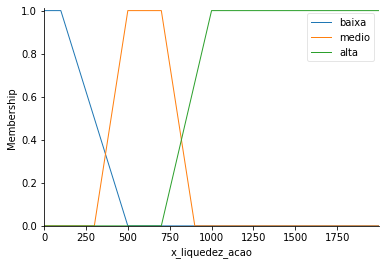

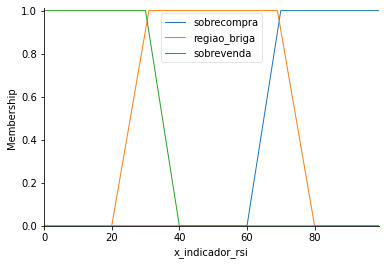

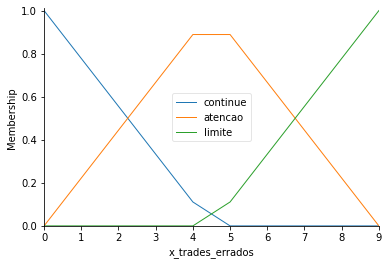

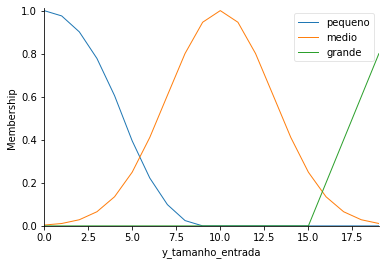

In [766]:
x_liquedez_acao.view()
x_indicador_rsi.view()
x_trades_errados.view()
y_tamanho_entrada.view()

## Regras

In [795]:
# melhores casos
rule1 = ctrl.Rule(x_liquedez_acao['alta'] 
                  | x_indicador_rsi['sobrecompra']
                  & x_trades_errados['continue']
                  , y_tamanho_entrada['grande'])

# medio casos
rule2 = ctrl.Rule(x_liquedez_acao['medio'] 
                  | x_indicador_rsi['regiao_briga']
                  & x_trades_errados['atencao']
                  , y_tamanho_entrada['medio'])

# piores casos: limite
rule3 = ctrl.Rule(x_liquedez_acao['baixa'] 
                  | x_indicador_rsi['sobrevenda']
                  & x_trades_errados['limite']
                  , y_tamanho_entrada['pequeno'])

## Sistema de Controle

In [796]:
tamanho_entrada_ctrl = ctrl.ControlSystem([rule1,
                                   rule2,
                                   rule3])
tamanho_entrada_simulador = ctrl.ControlSystemSimulation(tamanho_entrada_ctrl)

## Teste 01 (bom)

## Input

In [797]:
total_capital = 1000
investimento_max_por_trade = 0.2

# Entrando com alguns valores para qualidade da comida e do serviço
tamanho_entrada_simulador.input['x_liquedez_acao'] = 1500
tamanho_entrada_simulador.input['x_indicador_rsi'] = 99
tamanho_entrada_simulador.input['x_trades_errados'] = 2

## Fuzzyfy

In [798]:
# Calculate rules, taking inputs and accumulating outputs
tamanho_entrada_simulador.compute()

## Output

In [799]:
total_trade = tamanho_entrada_simulador.output["y_tamanho_entrada"]

print(f'Percentual aplicado no trade: {total_trade}%')
print(f'Valor total aplicado: R$ {(total_capital*total_trade/100)}')

Percentual aplicado no trade: 17.666666666666664%
Valor total aplicado: R$ 176.66666666666663


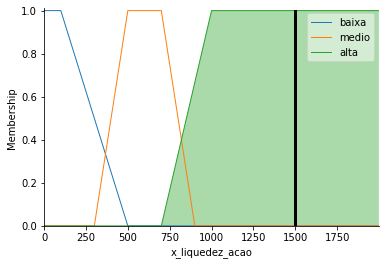

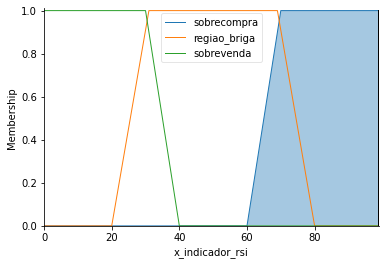

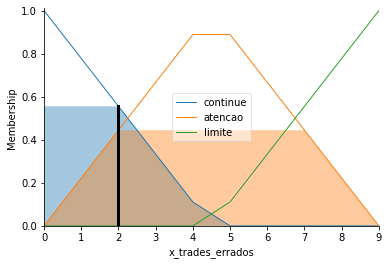

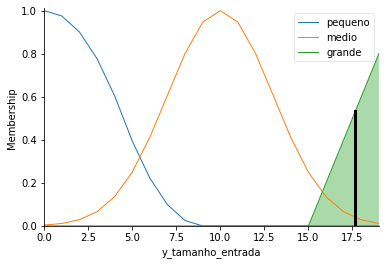

In [800]:
x_liquedez_acao.view(sim=tamanho_entrada_simulador)
x_indicador_rsi.view(sim=tamanho_entrada_simulador)
x_trades_errados.view(sim=tamanho_entrada_simulador)
y_tamanho_entrada.view(sim=tamanho_entrada_simulador)

## Teste 02 (regular)

In [801]:
total_capital = 1000
investimento_max_por_trade = 0.2

# Entrando com alguns valores para qualidade da comida e do serviço
tamanho_entrada_simulador.input['x_liquedez_acao'] = 600
tamanho_entrada_simulador.input['x_indicador_rsi'] = 50
tamanho_entrada_simulador.input['x_trades_errados'] = 5

## Fuzzyfy

In [802]:
# Calculate rules, taking inputs and accumulating outputs
tamanho_entrada_simulador.compute()

## Output

In [803]:
total_trade = tamanho_entrada_simulador.output["y_tamanho_entrada"]

print(f'Percentual aplicado no trade: {total_trade}%')
print(f'Valor total aplicado: R$ {(total_capital*total_trade/100)}')

Percentual aplicado no trade: 9.990602929075704%
Valor total aplicado: R$ 99.90602929075705


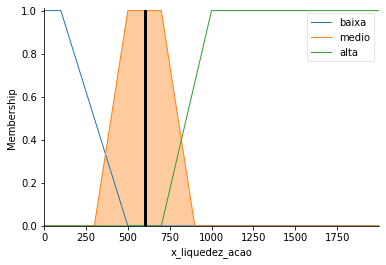

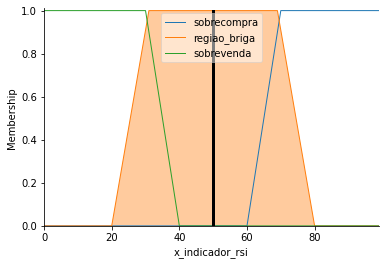

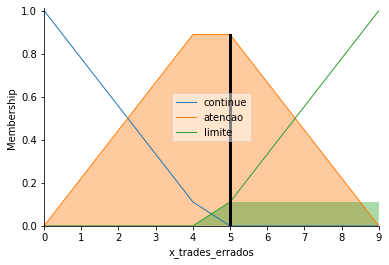

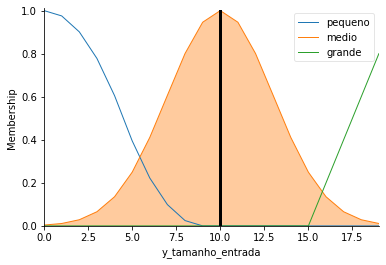

In [804]:
x_liquedez_acao.view(sim=tamanho_entrada_simulador)
x_indicador_rsi.view(sim=tamanho_entrada_simulador)
x_trades_errados.view(sim=tamanho_entrada_simulador)
y_tamanho_entrada.view(sim=tamanho_entrada_simulador)

## Teste 03 (ruim)

In [805]:
total_capital = 1000
investimento_max_por_trade = 0.2

# Entrando com alguns valores para qualidade da comida e do serviço
tamanho_entrada_simulador.input['x_liquedez_acao'] = 100
tamanho_entrada_simulador.input['x_indicador_rsi'] = 50
tamanho_entrada_simulador.input['x_trades_errados'] = 9

## Fuzzyfy

In [806]:
# Calculate rules, taking inputs and accumulating outputs
tamanho_entrada_simulador.compute()

## Output

In [807]:
total_trade = tamanho_entrada_simulador.output["y_tamanho_entrada"]

print(f'Percentual aplicado no trade: {total_trade}%')
print(f'Valor total aplicado: R$ {(total_capital*total_trade/100)}')

Percentual aplicado no trade: 2.6433470507544583%
Valor total aplicado: R$ 26.433470507544584


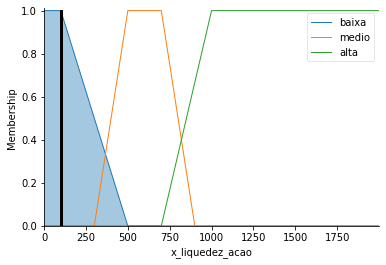

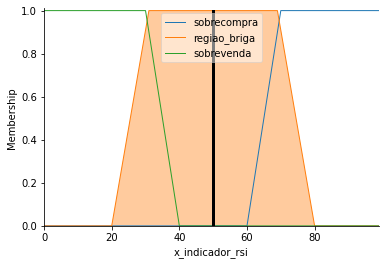

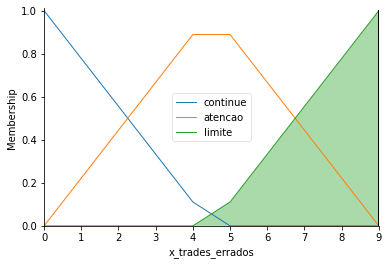

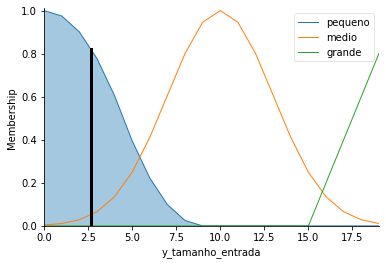

In [808]:
x_liquedez_acao.view(sim=tamanho_entrada_simulador)
x_indicador_rsi.view(sim=tamanho_entrada_simulador)
x_trades_errados.view(sim=tamanho_entrada_simulador)
y_tamanho_entrada.view(sim=tamanho_entrada_simulador)

---